The first block is copied from Quantopian with a little bit modification. 

it contains some basic function, the usage is self-explanatory

special note: the objective function is fitness

you can incorporate other penalties such as low beta, maximun drawdown, etc.. to further regularize your portfolio

the solve_weights function does the constrained optimization, you can specify constrains on parameter W. refer scipy.optimize for detailed usage

In [4]:
from numpy import matrix, array, zeros, empty, sqrt, ones, dot, append, mean, cov, transpose, linspace
from numpy.linalg import inv, pinv
import numpy as np
import scipy.optimize
import math
import pandas as pd

# This algorithm performs a Black-Litterman portfolio construction. The framework
# is built on the classical mean-variance approach, but allows the investor to 
# specify views about the over- or under- performance of various assets.
# Uses ideas from the Global Minimum Variance Portfolio 
# algorithm posted on Quantopian. Ideas also adopted from 
# http://www.quantandfinancial.com/2013/08/portfolio-optimization-ii-black.html.

# Compute the expected return of the portfolio.
def compute_mean(W,R):
    '''
    for one dimensional array, '*' calculate inner product
    W is 1*n, so is R
    '''
    return sum(R*W)

# Compute the variance of the portfolio.
def compute_var(W,C):
    '''
    doesn't it need to be transposed? W'CW. No numpy automatically transpose it for you.
    W is a 1*n matrix.
    '''
    return dot(dot(W, C), W)

# Combination of the two functions above - mean and variance of returns calculation. 
def compute_mean_var(W, R, C):
    return compute_mean(W, R), compute_var(W, C)

# Compute sharp ratio. risk_free_rate is set to three month US treasury bill
# the risk_free_rate is already deducted from the expected return
def compute_sharp_ratio(expected_return,sd,risk_free_rate=0):
    return (expected_return-risk_free_rate)/sd

# objective function you can add other constrains or targets here
def fitness(W, R, C,asset_beta):
    # W weight, R return, C correlation matrix, r target return
    # For given level of return r, find weights which minimizes portfolio variance.
    mean_1, var = compute_mean_var(W, R, C)
    # Penalty for not meeting stated portfolio return effectively serves as optimization constraint
    # Here, r is the 'target' return
    '''
    this will have to bechanged as higher the return the better. So abs(mean_1-r) should b changed.
    10 is a hyper parameter, as so in 1-2, sd in 10-15
    penalty = max(0.1*(r-mean_1),0)
    '''
    # directly maximize the sharp ratio
    sharp_ratio=compute_sharp_ratio(mean_1,sqrt(var))
    penalty= np.maximum(W@asset_beta-1,0)
    return -sharp_ratio+penalty+ var

# The return must be greater than 5%
def cons_return(W,R,r_target=0.05):
    temp=sum(R*W)
    # print('constraint on return is')
    # print(temp)
    return temp-r_target

# Solve for optimal portfolio weights
def solve_weights(R, C, rf, price_frame,asset_beta,r_target=0.05):
    n=len(R)
    W = ones([n])/n # Start optimization with equal weights
    b_ = [(0.02,0.4) for i in range(n)] # Bounds for decision variables
    c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. },
          {'type':'Ineq','fun':cons_max_drawdown,'args':(price_frame,)},
          {'type':'Ineq','fun':cons_return,'args':(R,r_target)}) 
    # Constraints - weights must sum to 1; return must be greater than 5%
    # 'target' return is the expected return on the market portfolio
    optimized = scipy.optimize.minimize(fitness, W, (R, C,asset_beta),
                                        method='SLSQP', constraints=c_,
                                        bounds=b_,options={'maxiter': 200})
    if not optimized.success:
        print('optimization failed!')
        print(r_target)
        # raise BaseException(optimized.message)
    return optimized.x

# Weights - array of asset weights (derived from market capitalizations)
# Expreturns - expected returns based on historical data
# Covars - covariance matrix of asset returns based on historical data
def assets_meanvar(returns):
    # Calculate expected returns
    expreturns=returns.mean(axis=0)    
    # Compute covariance matrix
    # As there are nan values, have to be converted to dataframe    
    covars = returns.cov()
    # Annualize expected returns and covariances
    # Assumes 255 trading days per year    
    expreturns = (1+expreturns)**255-1
    return expreturns, covars*255

# The max draw down must be smaller than 12%
# take an input of a numpy t*n numpy array 
def cons_max_drawdown(W,price_frame,drawdown_max=0.12):
    # the historical price of the portfolio 
    weighted=np.nansum(W*price_frame,axis=1)
    i=np.argmax(np.maximum.accumulate(weighted)-weighted)
    j=np.argmax(weighted[:i])
    max_down=(weighted[j]-weighted[i])/weighted[j]
    # print('constraint on max_down is ')
    # print(max_down)
    return max_down-drawdown_max

# get the place of the max and min since the abovve function is used in constraints
def min_max_drawdown(W,price_frame):
    weighted=np.nansum(W*price_frame,axis=1)
    i=np.argmax(np.maximum.accumulate(weighted)-weighted)
    j=np.argmax(weighted[:i])
    return i,j, weighted

This block generate hypothetical return data for illustration purpose, use real data for your case.

In [5]:
import numpy as np
import pandas as pd
df = pd.read_excel('xlsx/benchmark.xlsx', sheetname = 'Daily_Index_Price')
funds=pd.read_excel('xlsx/benchmark.xlsx',sheetname='daily_fund',index_col=0)
#risk_free=pd.read_excel('xlsx/h15T1M.xlsx',sheetname='H15T1M',index_col=0)
rf = 0.015

In [6]:
# use data from 2000.1.1 onward
df_sub = df.iloc[2:]
funds_sub=funds.iloc[2:]
#risk_free_sub=risk_free.iloc[2:]


In [7]:
df_new = pd.DataFrame(index = pd.to_datetime(df_sub.index))
for i in range(df_sub.shape[1]):
    df_new['asset'+str(i+1)]= pd.to_numeric(df_sub.iloc[:,i].values)

funds_new=pd.DataFrame(index=pd.to_datetime(funds_sub.index))
for i in range(funds_sub.shape[1]):
    funds_new['asset'+str(i+11)]=pd.to_numeric(funds_sub.iloc[:,i].values)

#risk_new=pd.DataFrame(index=pd.to_datetime(risk_free_sub.index),data=risk_free_sub.iloc[:,0].values)
#print(risk_free_sub)

In [8]:
# partially clear data, ideally trading days, but here weekdays
df_weekday = df_new[(df_new.index.weekday<5)]
funds_weekday=funds_new[(funds_new.index.weekday<5)]
# risk_weekday=risk_new[risk_new.index.weekday<5]
# use data from 2008-02-03 onwards

return_index_bench = df_weekday[df_weekday.index>'2009-02-03']
return_index_fund  = funds_weekday[funds_weekday.index>'2009-02-03']
# risk_new=risk_weekday[risk_weekday.index>'2008-02-03']
return_index=pd.merge(return_index_bench,return_index_fund,left_index=True,right_index=True)
# print(return_index.iloc[:10,:])

In [9]:
returns = return_index.values
#print(risk_new)

In [10]:
# compute daily return
daily_return = (returns[1:,:]-returns[:-1,:])/returns[:-1,:]
#daily_risk_free = np.power(risk_new.as_matrix(),1/21)-1

In [11]:
#daily_return = daily_return.transpose()
print(daily_return.shape)
#print(return_index.index[1:].shape)
df_return = pd.DataFrame(index = return_index[return_index.index>'2009-02-03'].index[1:], data = daily_return,dtype='float')
#df_return = pd.DataFrame(data = daily_return,index=return_index.index)

(2347, 20)


In [12]:
df_return

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2009-02-05,0.016366,-0.001322,-0.008035,-0.004617,0.017909,0.001119,-0.001073,0.003277,0.001065,0.003069,-0.030081,-0.009051,-0.020371,NaN,NaN,NaN,-0.000854,0.003875,NaN,-0.003515
2009-02-06,0.026896,0.021026,0.005633,0.039666,0.045869,0.039063,-0.002900,0.001000,-0.000687,0.007819,0.046336,0.038854,0.018349,NaN,NaN,NaN,0.000000,0.004289,NaN,0.001764
2009-02-09,0.001485,0.003888,-0.015098,0.019931,-0.013518,0.013058,0.006433,0.002518,0.000032,0.012031,0.005116,0.007715,-0.047447,NaN,NaN,NaN,-0.000855,0.000427,NaN,0.000000
2009-02-10,-0.049121,-0.027973,-0.001027,0.018181,-0.053593,-0.006073,0.002787,0.003199,0.003319,-0.008332,-0.003686,-0.015454,0.008197,NaN,NaN,NaN,0.001711,0.004126,NaN,-0.005282
2009-02-11,0.007955,-0.003247,0.000000,-0.001916,0.011905,-0.013966,-0.002068,-0.000937,0.003181,-0.018485,-0.031184,-0.031977,0.000000,NaN,NaN,NaN,0.004270,0.000567,NaN,-0.001770
2009-02-12,0.001739,-0.012733,-0.022889,-0.005630,-0.007313,-0.019601,-0.000120,-0.002786,0.003188,-0.012442,-0.020367,-0.019072,-0.013133,NaN,NaN,NaN,0.002551,-0.002408,NaN,-0.005319
2009-02-13,-0.009998,0.003599,0.005656,0.032339,0.012172,0.021412,-0.001808,-0.002849,-0.003108,0.011558,0.021162,0.020060,-0.001901,NaN,NaN,NaN,-0.000848,-0.007240,NaN,0.000000
2009-02-16,0.000000,-0.013748,0.007206,0.029557,0.000000,-0.012195,-0.003329,0.000000,0.000322,-0.012226,0.000000,-0.011828,0.005714,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000
2009-02-17,-0.045559,-0.024545,-0.017621,-0.029274,-0.074684,-0.048726,-0.003596,-0.005068,0.003679,-0.020937,-0.040902,-0.039216,-0.040404,NaN,NaN,NaN,0.000849,0.000000,NaN,-0.003565
2009-02-18,-0.000950,-0.003417,-0.009610,-0.047244,0.009918,-0.008716,-0.005513,-0.007258,-0.000832,-0.004608,-0.008340,-0.012613,-0.003947,NaN,NaN,NaN,0.003393,-0.006578,NaN,0.001789


start to compute prior weights


note: In the case there are 5 assets, change number correspondingly to your case 

In [13]:
expreturns, covars = assets_meanvar(df_return.iloc[:,10:])
R = expreturns # R is the vector of expected returns
C = covars # C is the covariance matrix
print(R)
#print(np.diag(C).shape)
print(C)

10    0.160313
11    0.118677
12    0.117374
13    0.134217
14    0.121578
15    0.058270
16    0.037418
17    0.111163
18    0.031894
19    0.043584
dtype: float64
          10        11        12        13        14        15        16  \
10  0.025769  0.025716  0.009262  0.008493  0.015780  0.001143 -0.001446   
11  0.025716  0.043478  0.010751  0.010689  0.020188  0.001401 -0.001479   
12  0.009262  0.010751  0.034393  0.002835  0.013603  0.001668 -0.000086   
13  0.008493  0.010689  0.002835  0.113406  0.015830  0.000998 -0.000436   
14  0.015780  0.020188  0.013603  0.015830  0.026696  0.002293 -0.000848   
15  0.001143  0.001401  0.001668  0.000998  0.002293  0.001722  0.000192   
16 -0.001446 -0.001479 -0.000086 -0.000436 -0.000848  0.000192  0.000806   
17  0.001287  0.001314  0.001950 -0.000582  0.002233  0.000749 -0.000061   
18 -0.001644 -0.001827 -0.000064 -0.000824 -0.000881  0.000208  0.000585   
19  0.003439  0.004993  0.002035  0.002344  0.003961  0.000999  0.000156   

In [14]:
import math
#daily_return=daily_return.transpose()
from scipy.stats import linregress
(_,n)=daily_return.shape
print(n)
asset_beta = np.ones(math.floor(n/2))
for i in range(0,math.floor(n/2)):
    # this is used for calculating beta when both funds
    # and benchmarks are present
    Y=daily_return[:,i]
    X=daily_return[:,i+10]
    mask=~np.isnan(X) & ~np.isnan(Y)
    asset_beta[i], alpha, r, _, _ =  linregress(X[mask],Y[mask])

20


In [15]:
print(asset_beta)
print(list(df_sub))
print(list(funds_sub))

[ 0.44114675  0.62970403  0.80303865  0.49458859  0.67057057  1.33560392
  0.65249423  0.39557404  0.68558832  1.13421914]
['SPX Index', 'MSCI Europe', 'TOPIX', 'SHCOMP', 'MSCI Asia', 'MSCI EM', 'Global bond', 'Hybond', 'JHDCGBIG', 'EM Gov Bond']
['america equity fund', 'europe dynamic a', 'japan equity a', 'china a-share opportunities a', 'asia pacific equity a', 'emerging markets equity', 'aggregate bond a', 'global high yield bond a', 'global government bond a', 'emerging markets debt a']


In [16]:
from math import floor
# use historical data as prior mean and cov
Pi = R - rf
print('historical average return')
returns=returns[:,10:]
# Solve for weights before incorporating views (example target = 0.05)
W = solve_weights(R, C, rf, returns, asset_beta)
mean_prior, var_prior = compute_mean_var(W, Pi+rf, C)
drawdown=0.12-cons_max_drawdown(W,returns,drawdown_max=0.12)
min_X,max_X,portfolio = min_max_drawdown(W,returns)

print('the name of the benchmarks are')
print(list(funds_sub))
print('the prior new weights is')
print(W)
print('the prior portfolio expected return is')
print(mean_prior)
print('the prior portfolio expected volatility is')
print(np.sqrt(var_prior))
print('the historical max_drawdown is')
print(drawdown)
print('the drawdown happens at: ')
print('max: year %s month %s',2009+floor(max_X/255),2+floor(max_X%365/21))
print(portfolio[max_X])
print('min: year %s month %s',2009+floor(min_X/255),2+floor(min_X%365/21))
print(portfolio[min_X])
print('the portfolio beta is')
print(W@asset_beta)



historical average return
the name of the benchmarks are
['america equity fund', 'europe dynamic a', 'japan equity a', 'china a-share opportunities a', 'asia pacific equity a', 'emerging markets equity', 'aggregate bond a', 'global high yield bond a', 'global government bond a', 'emerging markets debt a']
the prior new weights is
[ 0.03942643  0.02        0.02        0.04309894  0.02        0.02
  0.39747463  0.4         0.02        0.02      ]
the prior portfolio expected return is
0.0812706574154
the prior portfolio expected volatility is
0.0336324770386
the historical max_drawdown is
0.120000007034
the drawdown happens at: 
max: year %s month %s 2015 11
82.4895672441
min: year %s month %s 2016 2
72.590819755
the portfolio beta is
0.561463096371


In [25]:
def compute_historical_performance(daily_returns ,W):
    daily_returns[np.isnan(daily_returns)]=0
    ret_p = np.log(1+W@daily_returns)
    cum_p = np.exp(np.cumsum(ret_p))
    return cum_p

# Using retrun to calculate indexes is more accurate. Index is not price
cum_p=compute_historical_performance(daily_return[:,10:].transpose(),W)
print(np.isnan(cum_p).any())
print(W)

False
[ 0.03942643  0.02        0.02        0.04309894  0.02        0.02
  0.39747463  0.4         0.02        0.02      ]


the drawdown happens at: 
max: year %s month %s 2015 6
1.8099177718
min: year %s month %s 2016 4
1.64286610817



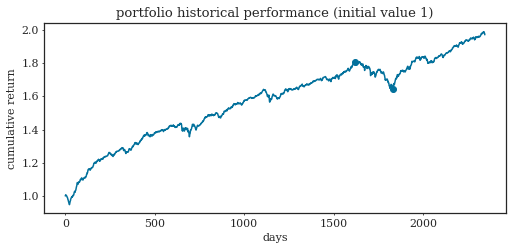

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

i=np.argmax(np.maximum.accumulate(cum_p)-cum_p)
j=np.argmax(cum_p[:i])
print('the drawdown happens at: ')
print('max: year %s month %s',2009+floor(j/255),2+floor(j%255/21))
print(cum_p[j])
print('min: year %s month %s',2009+floor(i/255),2+floor(i%255/21))
print(cum_p[i])
markers_on=[i,j]

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(range(cum_p.shape[0]), cum_p, c = 'xkcd:ocean blue',marker='o',markevery=markers_on)
ax.set_xlabel('days')
print()
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1)')

plt.legend(loc='best') 
plt.show()

varying the target return to plot prior m-v frontier. We reimplement the two functions. To get the return much more accurate

In [28]:
# redefine the optimizer, so return is not a constraint but a optimizer
def fitness_mv(W, R, C,asset_beta,r_target):
    # W weight, R return, C correlation matrix, r target return
    # For given level of return r, find weights which minimizes portfolio variance.
    mean_1, var = compute_mean_var(W, R, C)
    # Penalty for not meeting stated portfolio return effectively serves as optimization constraint
    # Here, r is the 'target' return
    '''
    this will have to bechanged as higher the return the better. So abs(mean_1-r) should b changed.
    10 is a hyper parameter, as so in 1-2, sd in 10-15
    penalty = max(0.1*(r-mean_1),0)
    '''
    # directly maximize the sharp ratio
    sharp_ratio=compute_sharp_ratio(mean_1,sqrt(var))
    penalty_beta= np.maximum(W@asset_beta-1,0)
    penalty_returns = 100*abs(mean_1-r_target)
    return -sharp_ratio+penalty_beta+ penalty_returns

# Solve for optimal portfolio weights
def solve_weights_mv(R, C, rf, price_frame,asset_beta,r_target=0.05):
    n=len(R)
    W = ones([n])/n # Start optimization with equal weights
    b_ = [(0.02,0.4) for i in range(n)] # Bounds for decision variables
    c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. },
          {'type':'Ineq','fun':cons_max_drawdown,'args':(price_frame,)}) 
    # Constraints - weights must sum to 1; return must be greater than 5%
    # 'target' return is the expected return on the market portfolio
    optimized = scipy.optimize.minimize(fitness_mv, W, (R, C,asset_beta,r_target),
                                        method='SLSQP', constraints=c_,
                                        bounds=b_,options={'maxiter': 200})
    if not optimized.success:
        print('optimization failed!')
        print(r_target)
        # raise BaseException(optimized.message)
    return optimized.x


In [37]:

# plot the prior m-v frontier
n = 150
plot_mean = np.zeros(n)
plot_var = np.zeros(n)

for i in range(n):
    r_target = i*0.001
    W = solve_weights_mv(R, C, rf, returns, asset_beta,r_target)
    plot_mean[i], plot_var[i] = compute_mean_var(W, Pi+rf, C)

(150,)
[ 0.05162705  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705
  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705
  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705
  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705
  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705
  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705
  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705
  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705  0.05162705
  0.05162705  0.05162706  0.05162705  0.05162705  0.052       0.053       0.054
  0.055       0.056       0.057       0.058       0.059       0.06000002
  0.06099999  0.06200001  0.063       0.06399999  0.065       0.06599999
  0.06700001  0.06799999  0.06900001  0.07000001  0.071       0.07200001
  0.07300001  0.07399999  0.075       0.07599999  0.077       0.07799999
  0.079       0.08        0.081      

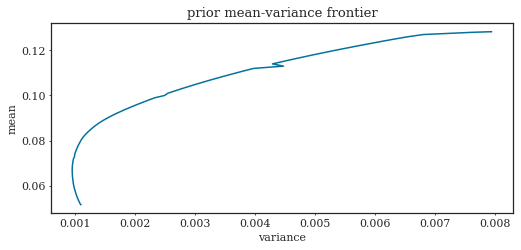

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

# plot_mean = np.append(plot_mean,0.08)
# plot_var = np.append(plot_var,0.004)
# ax.plot(plot_var, plot_mean,'bs', c = 'xkcd:ocean blue')
ax.plot(plot_var, plot_mean, c = 'xkcd:ocean blue')
ax.set_xlabel('variance')
ax.set_ylabel('mean')
ax.set_title('prior mean-variance frontier')

plt.legend(loc='best') 
plt.show()            

incorporate your view, compute posterior weights

In [39]:
list(funds_sub)

['america equity fund',
 'europe dynamic a',
 'japan equity a',
 'china a-share opportunities a',
 'asia pacific equity a',
 'emerging markets equity',
 'aggregate bond a',
 'global high yield bond a',
 'global government bond a',
 'emerging markets debt a']

In [19]:
# VIEWS ON ASSET PERFORMANCE
# asset 1 will out perform asset 2 by 3%, and
# that asset 1 will outperform asset 3 by 2%.
# that asset 5 will under outperform the benchmark by 5%
P = np.array([[0,0,1,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,1,0,0,0,0],
              [1,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0,0]])
Q = np.array([0.086,0.0622,0.055,0.1218,0.089,0.1157])


## note adjust tau to adjust your confidence about your view
tau = 0.025 # tau is a scalar indicating the uncertainty 
# in the CAPM (Capital Asset Pricing Model) prior
omega = dot(dot(dot(tau, P), C), transpose(P)) # omega represents 
# the uncertainty of our views. Rather than specify the 'confidence'
# in one's view explicitly, we extrapolate an implied uncertainty
# from market parameters.

# Compute equilibrium excess returns taking into account views on assets
sub_a = inv(dot(tau, C))
sub_b = dot(dot(transpose(P), inv(omega)), P)
sub_c = dot(inv(dot(tau, C)), Pi)
sub_d = dot(dot(transpose(P), inv(omega)), Q)
Pi_new = dot(inv(sub_a + sub_b), (sub_c + sub_d))         
# Perform a mean-variance optimization taking into account views          

new_weights = solve_weights(Pi_new + rf, C, rf, r_target = 0.08, daily_return = daily_return)
mean_new, var_new = compute_mean_var(new_weights, Pi_new + rf, C)
print('the posterior new weights is')
print(new_weights)
print('the posterior portfolio expected return is')
print(mean_new)
print('the posterior portfolio expected volatility is')
print(np.sqrt(var_new))

the posterior new weights is
[ 0.1         0.1         0.1         0.31022784  0.38977216]
the posterior portfolio expected return is
0.0600393163737
the posterior portfolio expected volatility is
0.0146885558362


varying the target return to plot posterior m-v frontier

In [20]:
# plot the posterior m-v frontier
n = 100
plot_mean = np.zeros(n)
plot_var = np.zeros(n)
for i in range(n):
    r_target = i*0.001
    new_weights = solve_weights(Pi_new+rf, C, rf, r_target = r_target, daily_return = daily_return)
    plot_mean[i], plot_var[i] = compute_mean_var(new_weights, Pi_new + rf, C) 

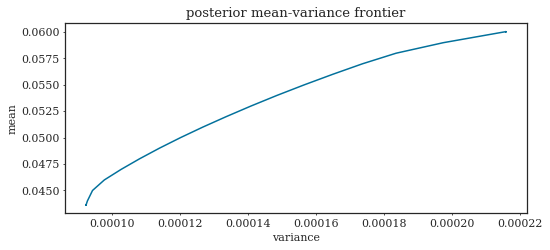

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(plot_var, plot_mean, c = 'xkcd:ocean blue')
ax.set_xlabel('variance')
ax.set_ylabel('mean')
ax.set_title('posterior mean-variance frontier')

plt.legend(loc='best') 
plt.show()            